In [1]:
from numpy import *
import numpy as np
import numpy.random
from sklearn.datasets import fetch_openml
import sklearn.preprocessing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from numpy_cca import CCAModel
from scipy.linalg import eig
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
def plot(digit: np.array):
    """
    plot an mnist digit.
    """
    plt.figure(0)
    plt.imshow(digit.reshape(28, 28), cmap=plt.cm.gray)
    plt.show()
    

def get_cov(X,Y):
    """
    return: the covariance matrix between X and Y
    """
    mean_X = np.mean(X, axis = 0)
    mean_Y = np.mean(Y, axis = 0)
    X_zeromean = X - mean_X
    Y_zeromean = Y - mean_Y
    
    N = len(X)
    
    cov = (1./N - 1)*X_zeromean.T@Y_zeromean
    return cov

### MNIST data

In [3]:
data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

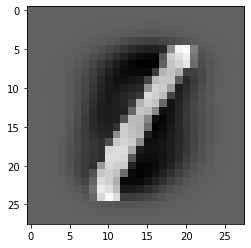

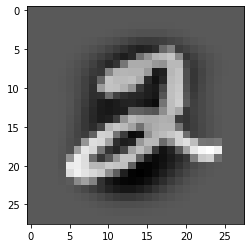

In [130]:
train_data = data[:60000].astype(float)
train_labels = labels[:60000].astype(int)
dev_data = data[60000:].astype(float)
dev_labels = labels[60000:].astype(int)

# normalize
train_data /= 255.
dev_data /= 255.

# remove mean

train_data = train_data - train_data.mean(axis=0, keepdims = True)
dev_data = dev_data - dev_data.mean(axis=0, keepdims = True)

# take the images of two specific digits
DIGIT1 = 1
DIGIT2 = 2

train_digit1 = train_data[train_labels==DIGIT1]
train_digit2 = train_data[train_labels==DIGIT2]
n = min(len(train_digit1), len(train_digit2))
train_digit1 = train_digit1[:n]
train_digit2 = train_digit2[:n]

# plot

plot(train_digit1[0])
plot(train_digit2[0])

### construct 2 views for cca

In [131]:

view1_digit1, view2_digit1 = list(zip(*zip(train_digit1, train_digit1[1:])))
view1_digit1 = np.array(view1_digit1)
view2_digit1 = np.array(view2_digit1)

view1_digit2, view2_digit2 = list(zip(*zip(train_digit2, train_digit2[1:])))
view1_digit2 = np.array(view1_digit2)
view2_digit2 = np.array(view2_digit2)

# make sure that the ith place in the two views stores the same kind of digit.
# we expect CCA to capture directions relating to digit identity.
view1 = np.concatenate([view1_digit1, view1_digit2]) # X
view2 = np.concatenate([view2_digit1, view2_digit2]) # Y

# construct view3 - the contrastive view - s.t it contains no corresponding digits 
view3 = np.concatenate([view2_digit2, view2_digit1])

## Perform CCA and "contrastive cca"

In [132]:
NUM_DIMS=16 # how many CCA directions to take

In [133]:
cca = CCAModel(NUM_DIMS)
out_cca = cca(view1, view2)

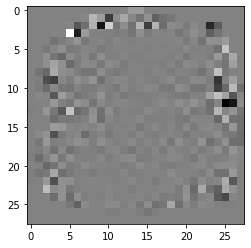

In [134]:
# A are the CCA directions for X. B are the CCA direction for Y. corr(XA, YB) is maximized. 
# Here, we take the 4th CCA direction.
v1 = out_cca["B"][4] 
# plot it
plot(v1.T)

### repeat above with "contrastive cca"

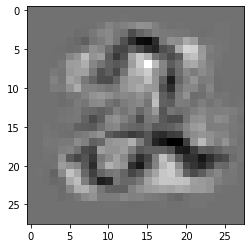

In [135]:
cov_XY = get_cov(view1, view2)
cov_XZ = get_cov(view1, view3)

A = np.linalg.pinv(cov_XZ)@cov_XY
B = np.linalg.pinv(cov_XZ.T)@cov_XY.T
# in the pdf we got the equations Bv_x = Rv_x and Av_y = Rv_y where R is the objective.
# I solve by SVD of A,B although it's not clear to me whether this is justified - they are not symmetric...
u1,s1,vt1 = np.linalg.svd(A)
u2,s2,vt2 = np.linalg.svd(B)
plot(vt2[4].T)